# Ejercicios de Práctica # 5

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import descartes 
import geopandas as gpd
import numpy as np 
from datetime import datetime
import folium
from folium.plugins import HeatMap
import warnings        
warnings.filterwarnings("ignore") 

# Parte 1

En esta actividad, se trabajará con una base de datos titulada Accidentalidad en Barranquilla, proporcionada por la Alcaldía Distrital de Barranquilla. Esta base contiene información sobre accidentes de tránsito ocurridos en el distrito de Barranquilla, obtenida de los informes policiales de accidentes de tránsito (IPAT). La base proporciona un registro detallado de cada accidente, permitiendo análisis sobre la frecuencia, severidad y ubicación de los accidentes en la ciudad.

In [2]:
df = pd.read_csv("C:/Users/jcami/OneDrive/Escritorio/DATAVIZ/Accidentalidad_en_Barranquilla_20240826.csv")
df.columns = df.columns.str.lower().str.replace(' ', '_') # Limpiar nombres de columnas

El análisis preliminar de la base de datos muestra que contiene 11 variables y 25,610 observaciones.

In [5]:
df.shape

(25610, 11)

Un examen superficial de las variables indica que algunas necesitarán ser normalizadas, renombradas o reformateadas para facilitar los análisis posteriores.

In [3]:
descripcion_df = pd.DataFrame({
    'Nombre_original': ["fecha_accidente", "hora_accidente", "gravedad_accidente", "clase_accidente", "sitio_exacto_accidente",
                        "cant_heridos_en_sitio_accidente", "cant_muertos_en_sitio_accidente", "cantidad_accidentes", "ano_accidente",
                        "mes_accidente", "dia_accidente"],
    'Nombre_recodificado': ["Fecha", "Hora", "Gravedad", "Clase", "Sitio", "Heridos", "Muertos", "Cantidad", "Año", "Mes", "Día"],
    'Tipo_original': ["Fecha", "Cadena", "Cadena", "Cadena", "Cadena", "Numérico", "Numérico", "Numérico", "Numérico", "Cadena", "Cadena"],
    'Tipo_modificado': ["Fecha", "Hora", "Categoría", "Categoría", "Cadena", "Numérico", "Numérico", "Numérico", "Numérico", "Categoría", "Categoría"]
})
descripcion_df

,Nombre_original,Nombre_recodificado,Tipo_original,Tipo_modificado
0,fecha_accidente,Fecha,Fecha,Fecha
1,hora_accidente,Hora,Cadena,Hora
2,gravedad_accidente,Gravedad,Cadena,Categoría
3,clase_accidente,Clase,Cadena,Categoría
4,sitio_exacto_accidente,Sitio,Cadena,Cadena
5,cant_heridos_en_sitio_accidente,Heridos,Numérico,Numérico
6,cant_muertos_en_sitio_accidente,Muertos,Numérico,Numérico
7,cantidad_accidentes,Cantidad,Numérico,Numérico
8,ano_accidente,Año,Numérico,Numérico
9,mes_accidente,Mes,Cadena,Categoría


Para examinar los datos almacenados en cada variable y determinar la presencia de datos faltantes, se utiliza la función `describe()` en pandas:

In [7]:
df.describe(include='all')

,fecha_accidente,hora_accidente,gravedad_accidente,clase_accidente,sitio_exacto_accidente,cant_heridos_en__sitio_accidente,cant_muertos_en__sitio_accidente,cantidad_accidentes,año_accidente,mes_accidente,dia_accidente
count,25610,25610,25610,25610,25610,9984.000000,252.000000,25610.000000,25610.000000,25610,25610
unique,2357,871,3,6,15365,NaN,NaN,NaN,NaN,12,7
top,2018-06-08T00:00:00.000,04:00:00:pm,Solo daños,Choque,CL 110 CR 9G,NaN,NaN,NaN,NaN,February,Tue
freq,34,408,15457,23819,77,NaN,NaN,NaN,NaN,2477,4009
mean,NaN,NaN,NaN,NaN,NaN,1.471655,1.035714,1.000195,2020.100547,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,1.156751,0.185946,0.013972,1.713887,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2018.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2019.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2020.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,2021.000000,NaN,NaN


Tras el análisis preliminar de la base, se estudiarán las variables individualmente. Primero, se modificarán los nombres de las columnas y se cambiará el tipo de datos de algunas variables:

In [4]:
# Renombrar columnas
df.columns = ["Fecha", "Hora", "Gravedad", "Clase", "Sitio", "Heridos", "Muertos", "Cantidad", "Año", "Mes", "Día"]

# Convertir tipos de datos
df["Gravedad"] = df["Gravedad"].astype('category')
df["Clase"] = df["Clase"].astype('category')
df["Mes"] = df["Mes"].astype('category')
df["Día"] = df["Día"].astype('category')
df["Fecha"] = pd.to_datetime(df["Fecha"], errors='coerce')

## Estudio de las Variables

### Fecha

En primera instancia, la variable `Fecha` no presenta problemas relacionados con la digitación o los datos faltantes:

In [ ]:
df['Fecha'].isna().sum()

Se visualizará la variable mediante un histograma:

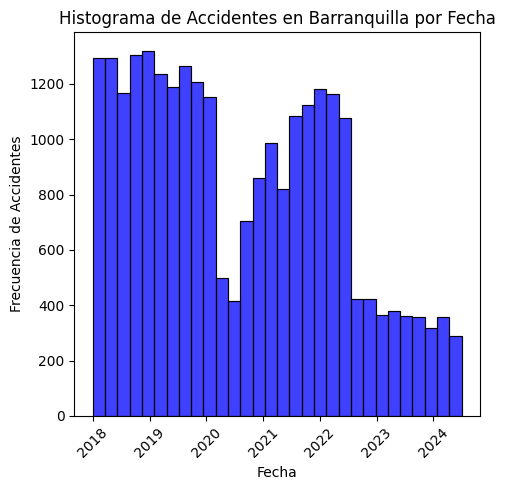

In [12]:
plt.figure(figsize=(5, 5))
sns.histplot(df['Fecha'], bins=30, color='blue', edgecolor='black')
plt.title('Histograma de Accidentes en Barranquilla por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de Accidentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Hora

La variable `Hora` almacena las horas en que ocurrieron los accidentes. Cambiaremos el tipo de la variable a hora utilizando `pd.to_datetime`. Primero, normalizamos el contenido y eliminamos caracteres que pueden dificultar la conversión:

In [13]:
df['Hora'] = pd.to_datetime(df['Hora'], format='%H:%M:%S', errors='coerce').dt.time

Luego, aseguramos que no haya datos faltantes y calculamos estadísticas descriptivas:

In [21]:
df['Hora'].isna().sum()
df['Hora'] = pd.to_timedelta(df['Hora'])
df['Hora_hora'] = df['Hora'].dt.total_seconds() // 3600

In [35]:
df['Hora'].describe()

count           25610
unique            871
top       04:00:00:pm
freq              408
Name: Hora, dtype: object

### Gravedad

La variable `Gravedad` indica la gravedad del accidente. Comenzamos construyendo una tabla de frecuencia para determinar el número de observaciones en cada condición y la posible existencia de datos faltantes:

In [24]:
df['Gravedad'].value_counts()

Gravedad
Solo daños     15457
Con heridos     9901
Con muertos      252
Name: count, dtype: int64

In [25]:
df['Gravedad'].isna().sum()

np.int64(0)

Como la tabla muestra que no hay datos faltantes, procedemos a crear una tabla con el conteo y el porcentaje de accidentes según su gravedad:

In [26]:
tabla_gravedad = df.groupby('Gravedad').size().reset_index(name='Conteo')
tabla_gravedad['Proporción'] = tabla_gravedad['Conteo'] / tabla_gravedad['Conteo'].sum()
tabla_gravedad['Porcentaje'] = (tabla_gravedad['Proporción'] * 100).round(2).astype(str) + '%'

tabla_gravedad

,Gravedad,Conteo,Proporción,Porcentaje
0,Con heridos,9901,0.386607,38.66%
1,Con muertos,252,0.009840,0.98%
2,Solo daños,15457,0.603553,60.36%


Utilizamos esta tabla para crear un diagrama de barras que muestra la cantidad de accidentes según su gravedad:

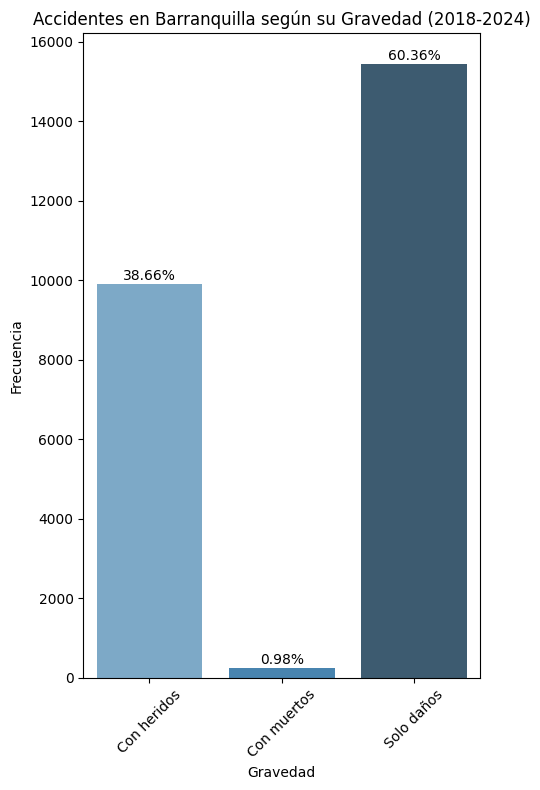

In [30]:
plt.figure(figsize=(5, 8))
sns.barplot(data=tabla_gravedad, x='Gravedad', y='Conteo', palette='Blues_d')
for index, row in tabla_gravedad.iterrows():
    plt.text(row.name, row['Conteo'] + 100, row['Porcentaje'], ha='center')
plt.title('Accidentes en Barranquilla según su Gravedad (2018-2024)')
plt.xlabel('Gravedad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Clase de Accidente

La variable `Clase` indica la clase de accidente. Construimos una tabla de frecuencias para verificar el número de observaciones por condición y comprobar datos faltantes:

In [31]:
df['Clase'].value_counts()

Clase
Choque            23819
Atropello          1344
Caida Ocupante      194
Otro                123
Volcamiento         117
Incendio             13
Name: count, dtype: int64

In [32]:
df['Clase'].isna().sum()

np.int64(0)

Como la tabla muestra que no hay datos faltantes, creamos una tabla con el conteo y el porcentaje de accidentes según su tipo:

In [33]:
df['Clase'] = df['Clase'].replace('Caida Ocupante', 'Caída')

tabla_clase = df.groupby('Clase').size().reset_index(name='Conteo')
tabla_clase['Proporción'] = tabla_clase['Conteo'] / tabla_clase['Conteo'].sum()
tabla_clase['Porcentaje'] = (tabla_clase['Proporción'] * 100).round(2).astype(str) + '%'

tabla_clase

,Clase,Conteo,Proporción,Porcentaje
0,Atropello,1344,0.052480,5.25%
1,Caída,194,0.007575,0.76%
2,Choque,23819,0.930066,93.01%
3,Incendio,13,0.000508,0.05%
4,Otro,123,0.004803,0.48%
5,Volcamiento,117,0.004569,0.46%


Creamos un diagrama de barras para visualizar la cantidad de accidentes según su clase:

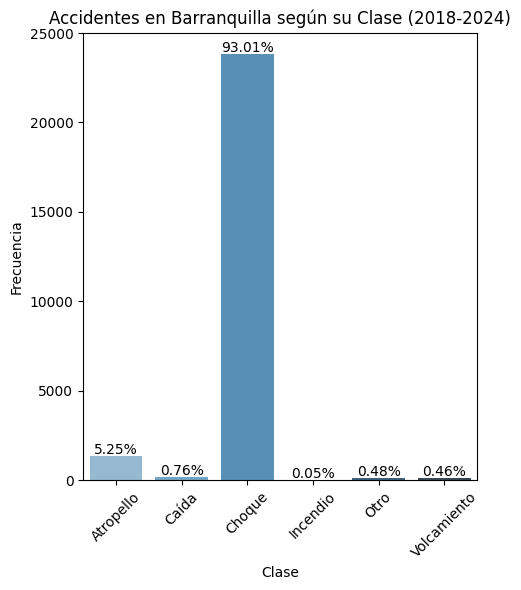

In [41]:
plt.figure(figsize=(5, 6))
sns.barplot(data=tabla_clase, x='Clase', y='Conteo', palette='Blues_d')
for index, row in tabla_clase.iterrows():
    plt.text(row.name, row['Conteo'] + 100, row['Porcentaje'], ha='center')
plt.title('Accidentes en Barranquilla según su Clase (2018-2024)')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Año

Para la variable `Año`, comenzamos construyendo una tabla de frecuencia para comprobar datos faltantes y calculando estadísticas descriptivas. Luego, visualizamos el número de accidentes a lo largo de los años:

In [35]:
df['Año'].value_counts()

Año
2018    5898
2019    5645
2021    4700
2022    3683
2020    3281
2023    1662
2024     741
Name: count, dtype: int64

In [36]:
tabla_año = df.groupby('Año').size().reset_index(name='Conteo')
tabla_año['Proporción'] = tabla_año['Conteo'] / tabla_año['Conteo'].sum()
tabla_año['Porcentaje'] = (tabla_año['Proporción'] * 100).round(2).astype(str) + '%'

tabla_año

,Año,Conteo,Proporción,Porcentaje
0,2018,5898,0.230301,23.03%
1,2019,5645,0.220422,22.04%
2,2020,3281,0.128114,12.81%
3,2021,4700,0.183522,18.35%
4,2022,3683,0.143811,14.38%
5,2023,1662,0.064897,6.49%
6,2024,741,0.028934,2.89%


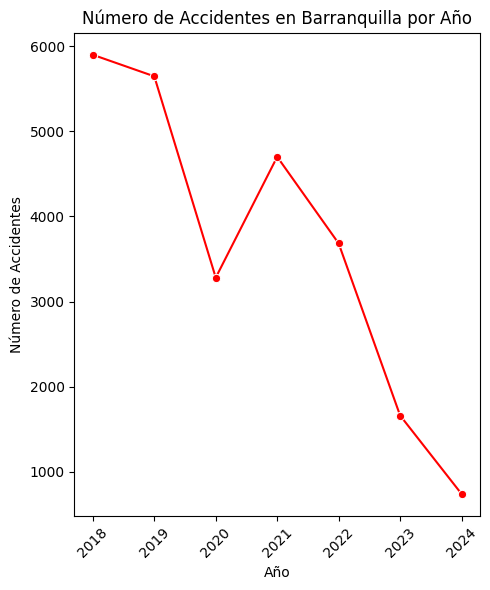

In [40]:
plt.figure(figsize=(5, 6))
sns.lineplot(data=tabla_año, x='Año', y='Conteo', marker='o', color='red')
plt.title('Número de Accidentes en Barranquilla por Año')
plt.xlabel('Año')
plt.ylabel('Número de Accidentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Mes y Día

Para las variables `Mes` y `Día`, creamos tablas de frecuencia para cada una y generamos gráficos de barras para visualizar la distribución de los accidentes a lo largo del año y de la semana:

In [43]:
df['Mes'].value_counts()

Mes
February     2477
March        2446
January      2349
December     2189
May          2121
June         2103
October      2090
April        2010
November     1995
September    1980
July         1932
August       1918
Name: count, dtype: int64

In [44]:
df['Día'].value_counts()

Día
Tue    4009
Fri    3920
Wed    3839
Mon    3774
Thu    3756
Sat    3735
Sun    2577
Name: count, dtype: int64

In [48]:
tabla_mes = df.groupby('Mes').size().reset_index(name='Conteo')
tabla_mes['Proporción'] = tabla_mes['Conteo'] / tabla_mes['Conteo'].sum()
tabla_mes['Porcentaje'] = (tabla_mes['Proporción'] * 100).round(2).astype(str) + '%'
tabla_mes

,Mes,Conteo,Proporción,Porcentaje
0,April,2010,0.078485,7.85%
1,August,1918,0.074893,7.49%
2,December,2189,0.085474,8.55%
3,February,2477,0.096720,9.67%
4,January,2349,0.091722,9.17%
5,July,1932,0.075439,7.54%
6,June,2103,0.082116,8.21%
7,March,2446,0.095510,9.55%
8,May,2121,0.082819,8.28%
9,November,1995,0.077899,7.79%


In [49]:
tabla_dia = df.groupby('Día').size().reset_index(name='Conteo')
tabla_dia['Proporción'] = tabla_dia['Conteo'] / tabla_dia['Conteo'].sum()
tabla_dia['Porcentaje'] = (tabla_dia['Proporción'] * 100).round(2).astype(str) + '%'
tabla_dia 

,Día,Conteo,Proporción,Porcentaje
0,Fri,3920,0.153065,15.31%
1,Mon,3774,0.147364,14.74%
2,Sat,3735,0.145841,14.58%
3,Sun,2577,0.100625,10.06%
4,Thu,3756,0.146661,14.67%
5,Tue,4009,0.156540,15.65%
6,Wed,3839,0.149902,14.99%


In [36]:
plt.figure(figsize=(8, 6))
sns.barplot(data=tabla_dia, x='Día', y='Conteo', palette='Blues_d')
for index, row in tabla_dia.iterrows():
    plt.text(row.name, row['Conteo'] + 10, row['Porcentaje'], ha='center')
plt.title('Accidentes por Día de la Semana')
plt.xlabel('Día')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'tabla_dia' is not defined

<Figure size 800x600 with 0 Axes>

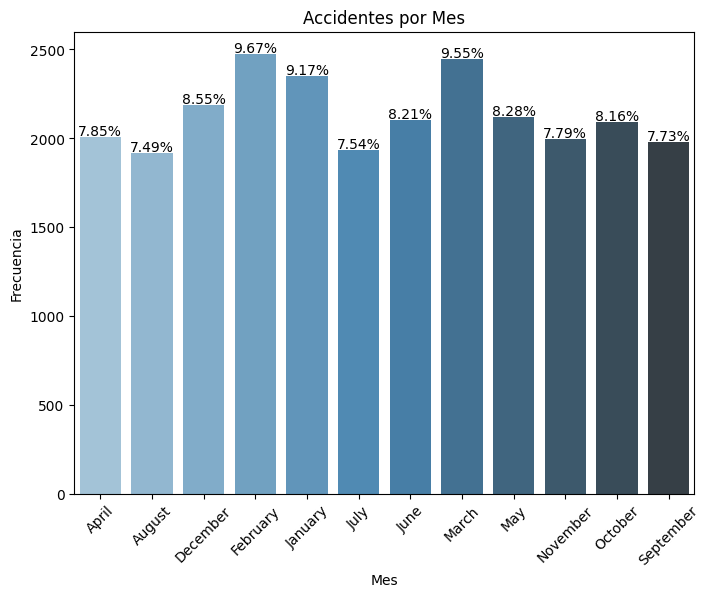

In [55]:
plt.figure(figsize=(8, 6))
sns.barplot(data=tabla_mes, x='Mes', y='Conteo', palette='Blues_d')
for index, row in tabla_mes.iterrows():
    plt.text(row.name, row['Conteo'] + 10, row['Porcentaje'], ha='center')
plt.title('Accidentes por Mes')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

### Sitio

In [8]:
file_path = "C:/Users/jcami/OneDrive/Escritorio/DATAVIZ/accidentes_lon_lat.xlsx"
resultados = pd.read_excel(file_path)
resultados_clean = resultados.dropna(subset=['lat', 'lon'])

In [32]:
mapa = folium.Map(location=[10.9639, -74.7967], zoom_start=12)
heat_data = [[row['lat'], row['lon']] for index, row in resultados_clean.iterrows()]
HeatMap(
    heat_data,
    radius=4,       # Ajusta el radio de los puntos en el mapa
    blur=5,         # Ajusta el desenfoque de los puntos
    max_zoom=10     # Ajusta el nivel máximo de zoom para el mapa de calor
).add_to(mapa)

In [33]:
mapa.save("mapa_accidentes_barranquilla.html")
mapa

### Heridos y Muertos

Para las variables `Heridos` y `Muertos`, se verifica la cantidad de datos faltantes y se calcula la estadística descriptiva para cada variable. Luego se crea un gráfico para visualizar la cantidad total de heridos y muertos en los accidentes:

In [57]:
df['Heridos'].isna().sum()
df['Muertos'].isna().sum()

df['Heridos'] = df['Heridos'].fillna(0)
df['Muertos'] = df['Muertos'].fillna(0)

heridos_totales = df['Heridos'].sum()
muertos_totales = df['Muertos'].sum()

heridos_totales, muertos_totales

(np.float64(14693.0), np.float64(261.0))

# Parte 2

In [37]:
# Cargar y limpiar los datos
df = pd.read_excel("C:/Users/jcami/Downloads/precios_2023.xlsx")
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [3]:
# Resumen de la base de datos
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267943 entries, 0 to 267942
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   bandera           267943 non-null  object
 1   nombre_comercial  267943 non-null  object
 2   producto          267943 non-null  object
 3   fecha_registro    267943 non-null  object
 4   departamento      267943 non-null  object
 5   municipio         267943 non-null  object
 6   valor_precio      267943 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 14.3+ MB
None


In [4]:
print(df.head(6))

  bandera                           nombre_comercial       producto  \
0  TERPEL        ESTACIONDESERVICIOFLUVIALBALSAJUNIN  GASOLINAMOTOR   
1  TERPEL             ESTACIONDESERVICIOBALSASANJOSE  GASOLINAMOTOR   
2  TERPEL        ESTACIONDESERVICIOFLUVIALBALSAJUNIN         DIESEL   
3  TERPEL             ESTACIONDESERVICIOBALSASANJOSE         DIESEL   
4  TERPEL  ESTACIONDESERVICIODISTRIBUIDORAELPORVENIR  GASOLINAMOTOR   
5  TERPEL  ESTACIONDESERVICIODISTRIBUIDORAELPORVENIR         DIESEL   

  fecha_registro departamento municipio  valor_precio  
0    01-Apr-2023     AMAZONAS   LETICIA         12968  
1    01-Apr-2023     AMAZONAS   LETICIA         13000  
2    01-Apr-2023     AMAZONAS   LETICIA         11800  
3    01-Apr-2023     AMAZONAS   LETICIA         11980  
4    01-Apr-2023     AMAZONAS   LETICIA         12605  
5    01-Apr-2023     AMAZONAS   LETICIA         11800  


In [5]:
cols_to_lower = ["bandera", "nombre_comercial", "producto", "departamento", "municipio"]
df[cols_to_lower] = df[cols_to_lower].apply(lambda x: x.str.lower())
df['bandera'] = df['bandera'].str.replace("zapatayvelasquez", "zapata")
df[cols_to_lower] = df[cols_to_lower].astype('category')
df['fecha_registro'] = pd.to_datetime(df['fecha_registro'], format='%d-%b-%Y')

In [6]:
print(df.describe(include='all'))

       bandera          nombre_comercial       producto  \
count   267943                    267943         267943   
unique      23                      5910              3   
top     terpel  edsautomotrizsanjosemina  gasolinamotor   
freq     94823                       546         127338   
mean       NaN                       NaN            NaN   
min        NaN                       NaN            NaN   
25%        NaN                       NaN            NaN   
50%        NaN                       NaN            NaN   
75%        NaN                       NaN            NaN   
max        NaN                       NaN            NaN   
std        NaN                       NaN            NaN   

                       fecha_registro departamento    municipio  valor_precio  
count                          267943       267943       267943  2.679430e+05  
unique                            NaN           33          910           NaN  
top                               NaN       narino 

In [7]:
bandera_freq = df['bandera'].value_counts().reset_index()
bandera_freq.columns = ['bandera', 'n']
bandera_freq['proporcion'] = bandera_freq['n'] / bandera_freq['n'].sum()
bandera_freq['porcentaje'] = bandera_freq['proporcion'].apply(lambda x: f"{x:.2%}")
print(bandera_freq)

         bandera      n  proporcion porcentaje
0         terpel  94823    0.353892     35.39%
1         primax  36112    0.134775     13.48%
2         biomax  32225    0.120268     12.03%
3         texaco  27092    0.101111     10.11%
4       petromil  17249    0.064376      6.44%
5   coomulpinort   8918    0.033283      3.33%
6    ayatawacoop   8057    0.030070      3.01%
7          zeuss   7488    0.027946      2.79%
8      petrobras   4871    0.018179      1.82%
9    discowacoop   3895    0.014537      1.45%
10          ecos   3613    0.013484      1.35%
11          esso   3502    0.013070      1.31%
12     petrdecol   3495    0.013044      1.30%
13    petrodecol   3337    0.012454      1.25%
14          puma   3059    0.011417      1.14%
15        discom   2917    0.010887      1.09%
16        octano   2221    0.008289      0.83%
17       plusmas   1806    0.006740      0.67%
18           pyb   1684    0.006285      0.63%
19          brio    719    0.002683      0.27%
20        zap

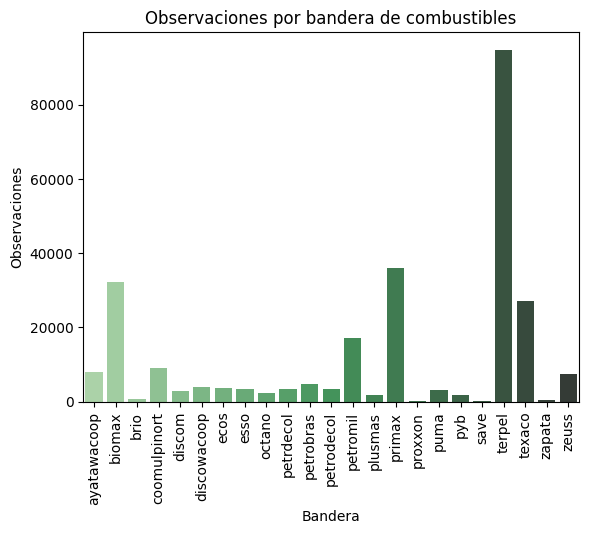

In [8]:
bandera_freq_sorted = bandera_freq.sort_values(by='n', ascending=False)
sns.barplot(x='bandera', y='n', hue='bandera', data=bandera_freq_sorted, palette='Greens_d', dodge=False)
plt.title("Observaciones por bandera de combustibles")
plt.xlabel("Bandera")
plt.ylabel("Observaciones")
plt.xticks(rotation=90)
plt.show()

In [9]:
# Análisis de la variable "Fecha de registro"
print(df['fecha_registro'].isna().sum())

0


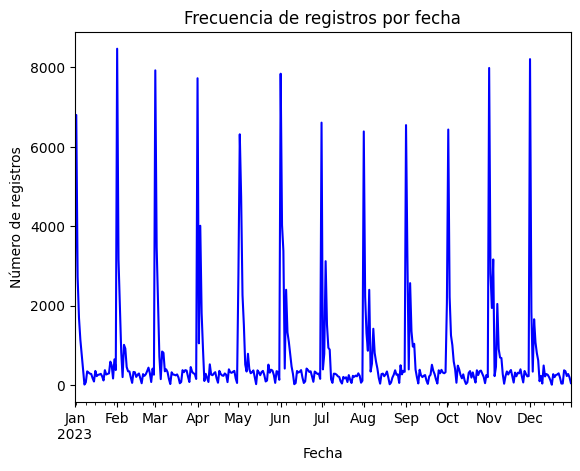

In [10]:
df['fecha_registro'].value_counts().sort_index().plot(kind='line', color='blue')
plt.title("Frecuencia de registros por fecha")
plt.xlabel("Fecha")
plt.ylabel("Número de registros")
plt.show()

In [11]:
df['mes'] = df['fecha_registro'].dt.month_name()
mes_freq = df['mes'].value_counts().reset_index()
mes_freq.columns = ['mes', 'n']
mes_freq['proporcion'] = mes_freq['n'] / mes_freq['n'].sum()
mes_freq['porcentaje'] = mes_freq['proporcion'].apply(lambda x: f"{x:.2%}")
print(mes_freq)

          mes      n  proporcion porcentaje
0        June  26887    0.100346     10.03%
1    November  25872    0.096558      9.66%
2         May  25590    0.095505      9.55%
3     January  22369    0.083484      8.35%
4    February  22206    0.082876      8.29%
5       March  22125    0.082574      8.26%
6      August  21959    0.081954      8.20%
7   September  21927    0.081835      8.18%
8       April  21635    0.080745      8.07%
9     October  19487    0.072728      7.27%
10   December  19433    0.072527      7.25%
11       July  18453    0.068869      6.89%


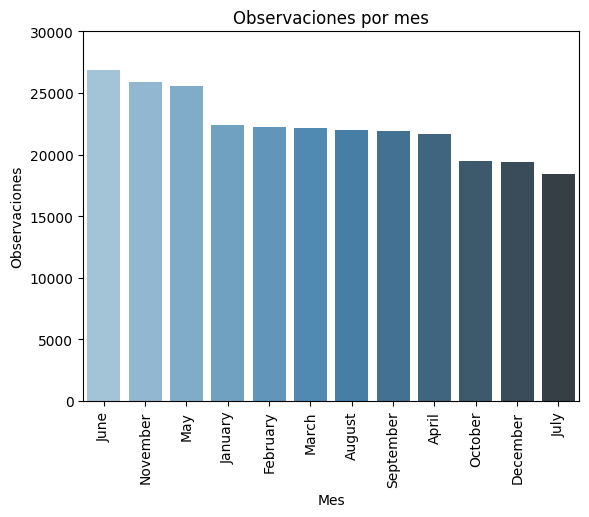

In [12]:
sns.barplot(x='mes', y='n',hue = 'mes',data=mes_freq, palette='Blues_d')
plt.title("Observaciones por mes")
plt.xlabel("Mes")
plt.ylabel("Observaciones")
plt.xticks(rotation=90)
plt.ylim(0, 30000)
plt.show()


In [13]:
departamento_freq = df['departamento'].value_counts().reset_index()
departamento_freq.columns = ['departamento', 'n']
departamento_freq['proporcion'] = departamento_freq['n'] / departamento_freq['n'].sum()
departamento_freq['porcentaje'] = departamento_freq['proporcion'].apply(lambda x: f"{x:.2%}")

print(departamento_freq)

        departamento      n  proporcion porcentaje
0             narino  31054    0.115898     11.59%
1          antioquia  25009    0.093337      9.33%
2   nortedesantander  21752    0.081181      8.12%
3      valledelcauca  18754    0.069992      7.00%
4       cundinamarca  16631    0.062069      6.21%
5         bogotad.c.  16031    0.059830      5.98%
6              cesar  15703    0.058606      5.86%
7          laguajira  13636    0.050891      5.09%
8          santander  10247    0.038243      3.82%
9          atlantico   8595    0.032078      3.21%
10            tolima   8014    0.029909      2.99%
11            boyaca   7769    0.028995      2.90%
12           cordoba   7440    0.027767      2.78%
13           bolivar   7027    0.026226      2.62%
14          putumayo   6610    0.024669      2.47%
15             huila   6355    0.023718      2.37%
16              meta   6250    0.023326      2.33%
17             cauca   5617    0.020963      2.10%
18         risaralda   5435    

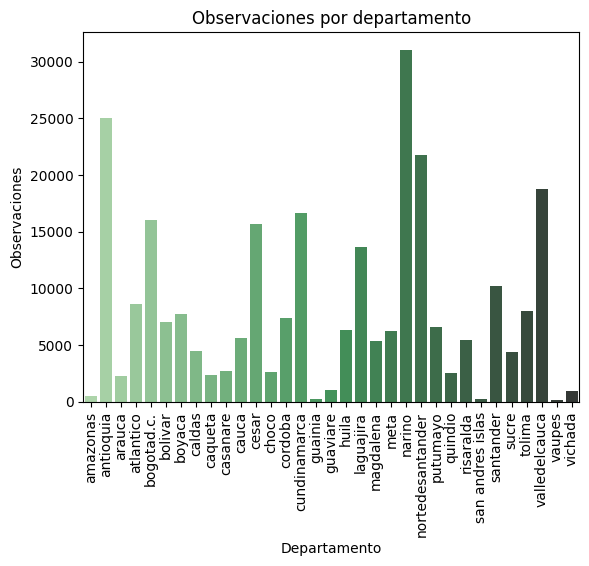

In [14]:
sns.barplot(x='departamento', y='n', hue = 'departamento', data=departamento_freq, palette='Greens_d')
plt.title("Observaciones por departamento")
plt.xlabel("Departamento")
plt.ylabel("Observaciones")
plt.xticks(rotation=90)
plt.show()

In [15]:
municipio_freq = df['municipio'].value_counts().reset_index().head(10)
municipio_freq.columns = ['municipio', 'n']
municipio_freq['proporcion'] = municipio_freq['n'] / municipio_freq['n'].sum()
municipio_freq['porcentaje'] = municipio_freq['proporcion'].apply(lambda x: f"{x:.2%}")

print(municipio_freq)

           municipio      n  proporcion porcentaje
0        bogota,d.c.  16031    0.275660     27.57%
1               cali   7388    0.127040     12.70%
2  sanandresdetumaco   6540    0.112458     11.25%
3    sanjosedecucuta   6183    0.106319     10.63%
4           medellin   5429    0.093354      9.34%
5       barranquilla   4366    0.075075      7.51%
6          aguachica   3660    0.062935      6.29%
7            pereira   2944    0.050623      5.06%
8          barbacoas   2870    0.049351      4.94%
9             maicao   2744    0.047184      4.72%


In [16]:
# Análisis de la variable "Nombre comercial"
df['nombre_comercial'] = df['nombre_comercial'].astype('category')
print(df['nombre_comercial'].isna().sum())

0


In [17]:
nombre_comercial_freq = df['nombre_comercial'].value_counts().reset_index()
nombre_comercial_freq.columns = ['nombre_comercial', 'n']
nombre_comercial_freq['proporcion'] = nombre_comercial_freq['n'] / nombre_comercial_freq['n'].sum()
nombre_comercial_freq['porcentaje'] = nombre_comercial_freq['proporcion'].apply(lambda x: f"{x:.2%}")
print(nombre_comercial_freq)

                         nombre_comercial    n  proporcion porcentaje
0                edsautomotrizsanjosemina  546    0.002038      0.20%
1         estaciondeserviciojltsanalberto  459    0.001713      0.17%
2          estaciondeserviciosanfrancisco  441    0.001646      0.16%
3     estaciondeservicioautomotrizfullleo  361    0.001347      0.13%
4                  estaciondeserviciootun  353    0.001317      0.13%
...                                   ...  ...         ...        ...
5905   estaciondeservicioyboteelhorizonte    2    0.000007      0.00%
5906        estaciondeserviciolavegasupia    2    0.000007      0.00%
5907              estaciondeserviciomario    2    0.000007      0.00%
5908              ancombustiblespacificrs    2    0.000007      0.00%
5909           e.d.scombustibleslaperlita    1    0.000004      0.00%

[5910 rows x 4 columns]


In [19]:
mapa_ant = gpd.read_file("C:/Users/jcami/Downloads/Python _Act/Python _Act/coordenadas/COLOMBIA/COLOMBIA.shp")

(np.float64(-82.48016529824997),
 np.float64(-66.10292604074994),
 np.float64(-5.109028823499952),
 np.float64(14.275649269500033))

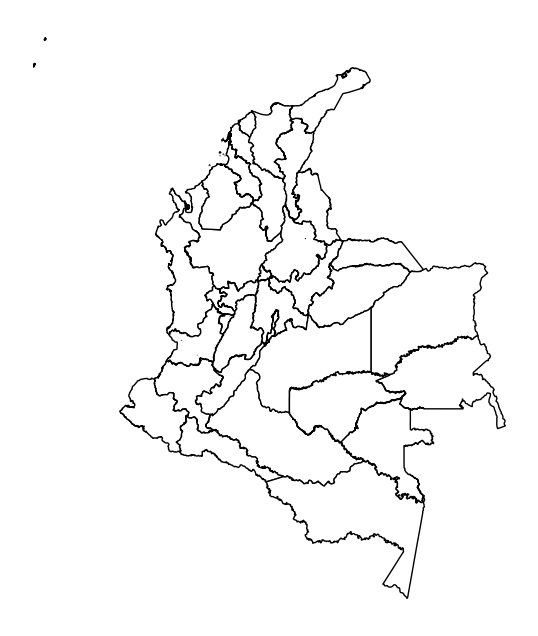

In [23]:
mapa_ant.plot(figsize=(30,8), edgecolor="black", color="white")
plt.axis('off')

In [26]:
munic_1 =df['departamento']
munic_2 = mapa_ant['DPTO_CNMBR']

In [27]:
mal_car = ['á', 'é', 'í', 'ó', 'ú', 'ñ', 'ü']
bien_car = ['a', 'e', 'i', 'o', 'u', 'n', 'u']

for j in range(len(mal_car)):
    munic_1 = munic_1.str.replace(mal_car[j], bien_car[j]).str.lower()
                                                                        
munic_1

0                 amazonas
1                 amazonas
2                 amazonas
3                 amazonas
4                 amazonas
                ...       
267938    nortedesantander
267939            putumayo
267940            putumayo
267941           santander
267942           santander
Name: departamento, Length: 267943, dtype: object

In [28]:
mal_car = ['á', 'é', 'í', 'ó', 'ú', 'ñ', 'ü']
bien_car = ['a', 'e', 'i', 'o', 'u', 'n', 'u']

for j in range(len(mal_car)):
    munic_2 = munic_2.str.replace(mal_car[j], bien_car[j]).str.lower()
                                                                       
munic_2

0                      antioquia
1                      atlantico
2                    bogota d.c.
3                        bolivar
4                         boyaca
5                         caldas
6                        caqueta
7                          cauca
8                          cesar
9                        cordoba
10                  cundinamarca
11                         choco
12                         huila
13                    la guajira
14                     magdalena
15                          meta
16                        nari?o
17            norte de santander
18                       quindio
19                     risaralda
20                     santander
21                         sucre
22                        tolima
23               valle del cauca
24                        arauca
25                      casanare
26                      putumayo
27                      amazonas
28                       guainia
29                      guaviare
30        

In [29]:
def match(a, b):
    lista=[]
    set_b = set(b)
    for i in range(len(a)):
        if a[i] in set_b:
            next
        else:
            lista+=[i]
    return lista

In [40]:
a2 = match(munic_2, munic_1)
munic_2[a2]

Series([], Name: DPTO_CNMBR, dtype: object)

In [34]:
munic_1.replace({'bogotad.c.':'cundinamarca',
                            'nortedesantander':'norte de santander',
                            'valledelcauca':'valle del cauca',
                           'laguajira':'la guajira'},
                inplace=True)

In [39]:
munic_2.replace({'archipielago de san andres':'san andres islas',
                'nari?o':'narino',
                'bogota d.c.':'cundinamarca'},
                inplace=True)

In [42]:
df["codigo"] = munic_1
mapa_ant["codigo"] = munic_2

In [43]:
Datos_tot = pd.merge(mapa_ant, df , on ='codigo', how = 'outer')

In [44]:
Datos_tot.columns

Index(['OBJECTID', 'DPTO_CCDGO', 'DPTO_NANO_', 'DPTO_CNMBR', 'DPTO_CACTO',
       'DPTO_NAREA', 'DPTO_CSMBL', 'DPTO_NANO', 'PAIS_PAIS_', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry', 'codigo', 'bandera', 'nombre_comercial',
       'producto', 'fecha_registro', 'departamento', 'municipio',
       'valor_precio', 'mes'],
      dtype='object')

In [45]:
Datos_tot_aux=Datos_tot[['codigo', 'bandera',
           'nombre_comercial', 'producto', 
           'fecha_registro', 'departamento', 
           'municipio', 'valor_precio', 
           'mes']]

In [46]:
Datos_tot_aux[Datos_tot_aux.isna().any(axis=1)]

,codigo,bandera,nombre_comercial,producto,fecha_registro,departamento,municipio,valor_precio,mes
